In [6]:
%load_ext autoreload
%autoreload 2
import SVAE2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pickle

PICKLE_DIR = '/home/solnik/floor_plans/Final Projects/pickles'

def save(obj, name, pickle_dir=PICKLE_DIR):
    print(f"SAVING {pickle_dir}/{name} ")
    with open(f'{pickle_dir}/{name}', "wb") as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load(name, pickle_dir=PICKLE_DIR):
    with open(f'{pickle_dir}/{name}', "rb") as handle:
        return pickle.load(handle)

In [8]:
import pandas as pd

In [9]:
geometries = pd.read_csv('data/swiss-dwellings/geometries.csv')

In [10]:
apartment_ids = list(set(geometries[geometries['unit_usage'] == 'RESIDENTIAL']['apartment_id']))

In [11]:
polygon_lengths = list(sorted(geometries['geometry'].apply(lambda x: len(x[len('POLYGON '):].split(',')))))

In [12]:
def get_geometries(apartment_id):
    return geometries[geometries['apartment_id'] == apartment_id]

In [13]:
import random
import functools

random.seed(10)
@functools.lru_cache
def get_entity_type_color(entity_type: str):
    return f"#{randrange(0, 0xffffff):0>6x}"

In [14]:
from shapely.geometry import LineString
from wktplot import WKTPlot
from random import randrange
from bokeh.io import export_png

def plot_aparment_with_color_getter(apartment_id: str, subtypes, get_color, save_dir):
    plot = WKTPlot(title=f"Apartment {apartment_id}")
    for i, row in get_geometries(apartment_id).iterrows():
        entity_subtype = row['entity_subtype']
        if entity_subtype in subtypes:
            plot.add_shape(row['geometry'], fill_color=get_entity_type_color(entity_subtype))
    export_png(plot.figure, filename=f'apt_{apartment_id}.png')

def plot_apartment(apartment_id: str, subtypes):
    plot = WKTPlot(title=f"Apartment", save_dir='/home/solnik/floor_plans/Final Projects/plans')
    for i, row in get_geometries(apartment_id).iterrows():
        entity_subtype = row['entity_subtype']
        if entity_subtype in subtypes:
            plot.add_shape(row['geometry'], fill_color=get_entity_type_color(entity_subtype))
    export_png(plot.figure, filename=f'/home/solnik/floor_plans/Final Projects/plans/apt_{apartment_id}.png')

In [15]:
for apartment_id in apartment_ids[:10]:
    print(apartment_id)
    plot_apartment(apartment_id, list(set(get_geometries(apartment_id)['entity_subtype'])))

c3bb6419b9afc9096e106d0b2297f2b8
c0ee3e46f38ec0afa1c01e644044fd74
3bf9f95b3e1945368e68fea08e45bae2
b90b930fd9bd9fd9c4f9b98d0f0835c4
098f9f31e57d6ac116ed159eb1488a1a
d3427ae83bc903afccecdcdfcba488bb
1844a57aa47ea745545eccb3a07e8806
cc0ac22450da7abccd14cbc1c16176fa
cf2dab5b01e8e46e9b2604e25ef7dffa
6385165f1f623b1921b8792a38bc3d38


In [16]:
import numpy as np

entity_types_unique, mask = np.unique(geometries['entity_type'], return_inverse=True)

In [17]:
geometries['entity_type_unique'] = mask

In [18]:
entity_types_unique

array(['area', 'feature', 'opening', 'separator'], dtype=object)

In [19]:
geometries['entity_subtype'].unique()

array(['LOBBY', 'STOREROOM', 'BALCONY', 'SANITARY_ROOMS', 'CLOAKROOM',
       'SPORTS_ROOMS', 'COMMON_KITCHEN', 'STAIRS', 'BATHTUB', 'SINK',
       'TOILET', 'KITCHEN', 'WALL', 'RAILING', 'WINDOW', 'DOOR',
       'ENTRANCE_DOOR', 'STAIRCASE', 'ELEVATOR', 'SHAFT', 'ROOM',
       'CORRIDOR', 'BATHROOM', 'LIVING_ROOM', 'SHOWER', 'COLUMN',
       'LIVING_DINING', 'VOID', 'NOT_DEFINED', 'OFFICE', 'DINING',
       'OUTDOOR_VOID', 'KITCHEN_DINING', 'BEDROOM', 'LOGGIA',
       'BASEMENT_COMPARTMENT', 'WASH_AND_DRY_ROOM', 'HEATING', 'GARAGE',
       'PRAM', 'LIGHTWELL', 'WINTERGARTEN', 'BUILT_IN_FURNITURE',
       'TECHNICAL_AREA', 'BIKE_STORAGE', 'WASHING_MACHINE', 'RAMP',
       'TERRACE', 'BASEMENT', 'SALESROOM', 'OIL_TANK', 'FOYER',
       'OFFICE_SPACE', 'OFFICE_TECH_ROOM', 'CORRIDORS_AND_HALLS',
       'WAREHOUSE', 'CARPARK', 'MEETING_ROOM', 'OPEN_PLAN_OFFICE',
       'BREAK_ROOM', 'ARCHIVE', 'WAITING_ROOM', 'CANTEEN', 'MEDICAL_ROOM',
       'PHYSIO_AND_REHABILITATION', 'RADATION_THERAPY'

In [20]:
import shapely
import matplotlib.pyplot as plt
import rasterio.features
from shapely.geometry import Polygon

X, Y = 64, 64
#img = rasterio.features.rasterize([(geom, i) for i, geom in enumerate(geometries_apt10['geometry_polygons'])], out_shape=(X, Y))
#plt.imshow(img)

def geometry_rows_to_rasterized(rows, X=X, Y=Y):
    polygons = rows['geometry'].apply(lambda geom: shapely.wkt.loads(geom))
    xs = [x
    for polygon in polygons
    for x, y in polygon.exterior.coords[:]]

    ys = [y
    for polygon in polygons
    for x, y in polygon.exterior.coords[:]]
    min_x = min(xs)
    max_x = max(xs)
    min_y = min(ys)
    max_y = max(ys)

    def transform_polygon(polygon):
        coords = polygon.exterior.coords[:]
        return Polygon([(X * (x - min_x) / (max_x - min_x), Y * (y - min_y) /(max_y - min_y)) for x, y in coords])
    
    entity_subtypes = rows['entity_subtype']
    has_balcony = 'BALCONY' in entity_subtypes

    num_bathrooms = (entity_subtypes == 'BATHROOM').sum()
    num_bedrooms = (entity_subtypes == 'BEDROOM').sum()

    return pd.Series(
        {
            'apartment_id': rows['apartment_id'].iloc[0], 
            'raster': rasterio.features.rasterize([(transform_polygon(polygon), i + 1) for i, polygon in zip(rows['entity_type_unique'], polygons)], out_shape=(X, Y)),
            'balcony': has_balcony,
            'bath': num_bathrooms,
            'bed': num_bedrooms,
        })     

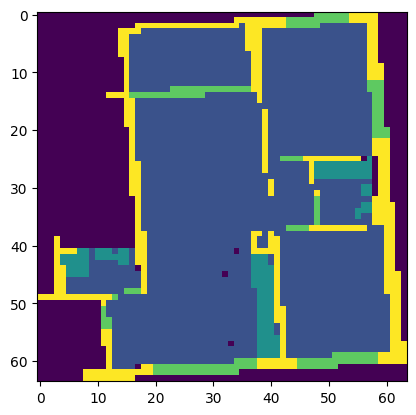

In [21]:
apt_1 = get_geometries(apartment_ids[0])
plt.imshow(geometry_rows_to_rasterized(apt_1)['raster'])

In [16]:
geometries = geometries[geometries['unit_usage'] == 'RESIDENTIAL']
geometries = geometries[['apartment_id', 'entity_type_unique', 'geometry', 'entity_subtype']]

geometries_rasterized = geometries.groupby('apartment_id').apply(geometry_rows_to_rasterized)

In [17]:
geometries_rasterized_saved = geometries_rasterized.copy()

In [18]:
geometries_rasterized = geometries_rasterized[geometries_rasterized['bath'] < 9]
geometries_rasterized = geometries_rasterized[geometries_rasterized['bed'] < 9]

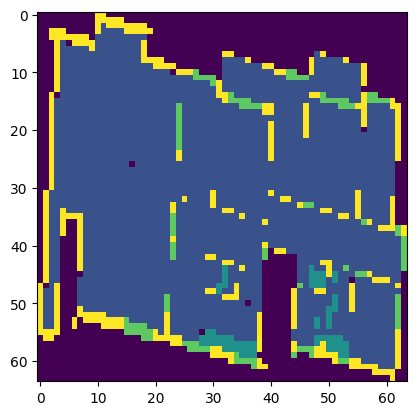

In [23]:
import matplotlib.pyplot as plt
import rasterio.features

plt.imshow(geometries_rasterized[geometries_rasterized['bath'] == 4].iloc[0]['raster'])

In [22]:
#save(geometries_rasterized, 'geometries_rasterized_1')
geometries_rasterized = load('geometries_rasterized_1')

In [24]:
numpy_arr_with_labels = geometries_rasterized.to_numpy()
numpy_arr_geometries = numpy_arr_with_labels[:, 1]

numpy_arr_baths = numpy_arr_with_labels[:, 3]
numpy_arr_beds = numpy_arr_with_labels[:, 4]

In [25]:
#save(numpy_arr_geometries, 'numpy_arr_geometries')
#save(numpy_arr_beds, 'numpy_arr_beds')
#save(numpy_arr_baths, 'numpy_arr_baths')
numpy_arr_geometries = load('numpy_arr_geometries')
numpy_arr_beds = load('numpy_arr_beds')
numpy_arr_baths = load('numpy_arr_baths')

In [26]:
#save(entity_types_unique, 'entity_types_unique_1')
entity_types_unique = load('entity_types_unique_1')

In [27]:
import numpy as np

In [28]:
def stack_and_int(arr):
    arr = np.stack(arr)
    arr.shape
    return arr.astype(np.int)

In [29]:
numpy_arr_geometries = stack_and_int(numpy_arr_geometries)
numpy_arr_beds = stack_and_int(numpy_arr_beds)
numpy_arr_baths = stack_and_int(numpy_arr_baths)

/tmp/ipykernel_12121/4126886576.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return arr.astype(np.int)


In [30]:
import torch

geometries_tensor = torch.from_numpy(numpy_arr_geometries)
beds_tensor = torch.from_numpy(numpy_arr_beds)
baths_tensor = torch.from_numpy(numpy_arr_baths)

In [31]:
X = 64
Y = 64

In [32]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import Tensor
from math import prod
from typing import Tuple

NUM_PIXELS = X * Y

In [44]:
tensors = [geometries_tensor, beds_tensor, baths_tensor]

In [34]:
geometries_tensor_reshaped = geometries_tensor.resize(geometries_tensor.shape[0], prod(geometries_tensor.shape[1:]))

/home/solnik/floor_plans/env/lib/python3.10/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [45]:
tensors = [(geometries_tensor_reshaped / 4).type(torch.float), beds_tensor.type(torch.float), baths_tensor.type(torch.float)]

In [46]:
pyro.clear_param_store()
vae, train_losses, test_losses = SVAE2.make_vae(tensors, 64, [64 * 4], epochs=101, lr=1e-3, aux_loss_multiplier=100, bed_bath_dim=9)

/home/solnik/floor_plans/env/lib/python3.10/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[epoch 000]  average training loss: 2001.3853
[epoch 000]  average training loss: 154.7146
[epoch 000] average test loss: 1977.8396
[epoch 000] average test loss: 130.7529
[epoch 001]  average training loss: 1937.8880
[epoch 001]  average training loss: 122.5561
[epoch 002]  average training loss: 1885.1083
[epoch 002]  average training loss: 110.3878
[epoch 003]  average training loss: 1840.6012
[epoch 003]  average training loss: 104.4741
[epoch 004]  average training loss: 1806.5628
[epoch 004]  average training loss: 104.0810
[epoch 005]  average training loss: 1781.0787
[epoch 005]  average training loss: 99.1470
[epoch 006]  average training loss: 1763.1192
[epoch 006]  average training loss: 100.5431
[epoch 007]  average training loss: 1750.2386
[epoch 007]  average training loss: 109.5969
[epoch 008]  average training loss: 1740.4965
[epoch 008]  average training loss: 113.5929
[epoch 009]  average training loss: 1731.5480
[epoch 009]  average training loss: 116.3558
[epoch 010

[epoch 083]  average training loss: 1624.6442
[epoch 083]  average training loss: 336.8134
[epoch 084]  average training loss: 1624.4724
[epoch 084]  average training loss: 316.0439
[epoch 085]  average training loss: 1624.1765
[epoch 085]  average training loss: 314.9428
[epoch 086]  average training loss: 1623.9527
[epoch 086]  average training loss: 311.3645
[epoch 087]  average training loss: 1623.6103
[epoch 087]  average training loss: 310.5247
[epoch 088]  average training loss: 1623.4638
[epoch 088]  average training loss: 311.0143
[epoch 089]  average training loss: 1623.0580
[epoch 089]  average training loss: 326.7417
[epoch 090]  average training loss: 1623.3352
[epoch 090]  average training loss: 323.4821
[epoch 090] average test loss: 1653.4312
[epoch 090] average test loss: 390.2499
[epoch 091]  average training loss: 1622.9477
[epoch 091]  average training loss: 310.1860
[epoch 092]  average training loss: 1622.6436
[epoch 092]  average training loss: 335.8122
[epoch 09

In [47]:
def reconstruct_img(vae, xs, ind, categorical=False):
    def get_cuda(i):
        return xs[i][ind: ind + 1].cuda()
    geom, beds, baths = xs[0][ind: ind + 1].cuda(),xs[1][ind: ind + 1].cuda(),xs[2][ind: ind + 1].cuda()
    # If beds or baths were not observed, we could use the neural net here.
    # beds_pis = vae.encoder_beds(geom)
    # bath_pis = vae.encoder_beds(geom)
    # beds = dist.Categorical(beds_pis).sample()
    # baths = dist.Categorical(beds_pis).sample()
    
    z_loc, z_scale = vae.encoder_z([geom, beds, baths])
    z = dist.Normal(z_loc, z_scale).sample()
    # decode the image (note we don't sample in image space)
    loc_img = vae.decoder([z, beds, baths])
    return loc_img

def from_cuda_and_resize(t, categorical=False, wall_thresh=None):
    numpy_arr = t.cpu().detach().numpy()
    if categorical:
        numpy_arr = numpy_arr.reshape(X * Y, 5)
        if wall_thresh:
            numpy_arr[:, 4][numpy_arr[:, 4] > wall_thresh] =4
        numpy_arr = np.argmax(numpy_arr, axis=1)
    
    res = numpy_arr.reshape(X, Y)
    return res

def get_pred_and_real(vae, ts, ind, categorical=False):
    t = ts[0][ind:ind + 1, :].cuda()
    img = reconstruct_img(vae, ts, ind)
    return from_cuda_and_resize(img, categorical=categorical), from_cuda_and_resize(t)

In [48]:
test_losses_pd = pd.Series([np.nan] * 101)
for i in range(10):
    test_losses_pd[10 * i] = test_losses[0][i]
    
test_losses_pd = test_losses_pd.interpolate()

<AxesSubplot: title={'center': 'ELBO Per Epoch for Continuous Bernoulli Bed-Bath Model with α = 100'}>

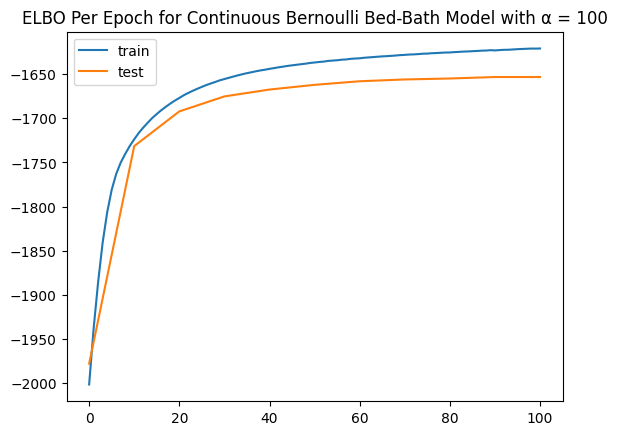

In [49]:
pd.DataFrame({'train': train_losses[0], 'test': test_losses_pd}).plot(title='ELBO Per Epoch for Continuous Bernoulli Bed-Bath Model with α = 100')

In [50]:
indicies = [9089, 39530, 23270, 25008, 27607, 18587]

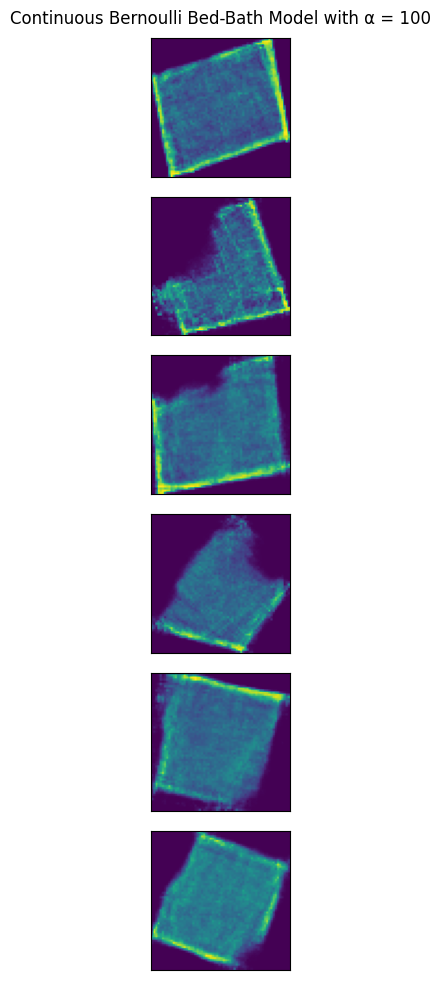

In [52]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(indicies), 1, sharex=True, sharey=True, figsize=[5, 10])
f.suptitle('Continuous Bernoulli Bed-Bath Model with α = 100')
imgs = []
for i, ind in enumerate(indicies):
    pred, real = get_pred_and_real(vae, tensors, ind, categorical=False)
    imgs.append(pred)
    axarr[i].imshow(pred)
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [53]:
save(imgs, 'Continuous Bernoulli Bed-Bath Model with alpha = 100')

SAVING /home/solnik/floor_plans/Final Projects/pickles/Continuous Bernoulli Bed-Bath Model with alpha = 100 


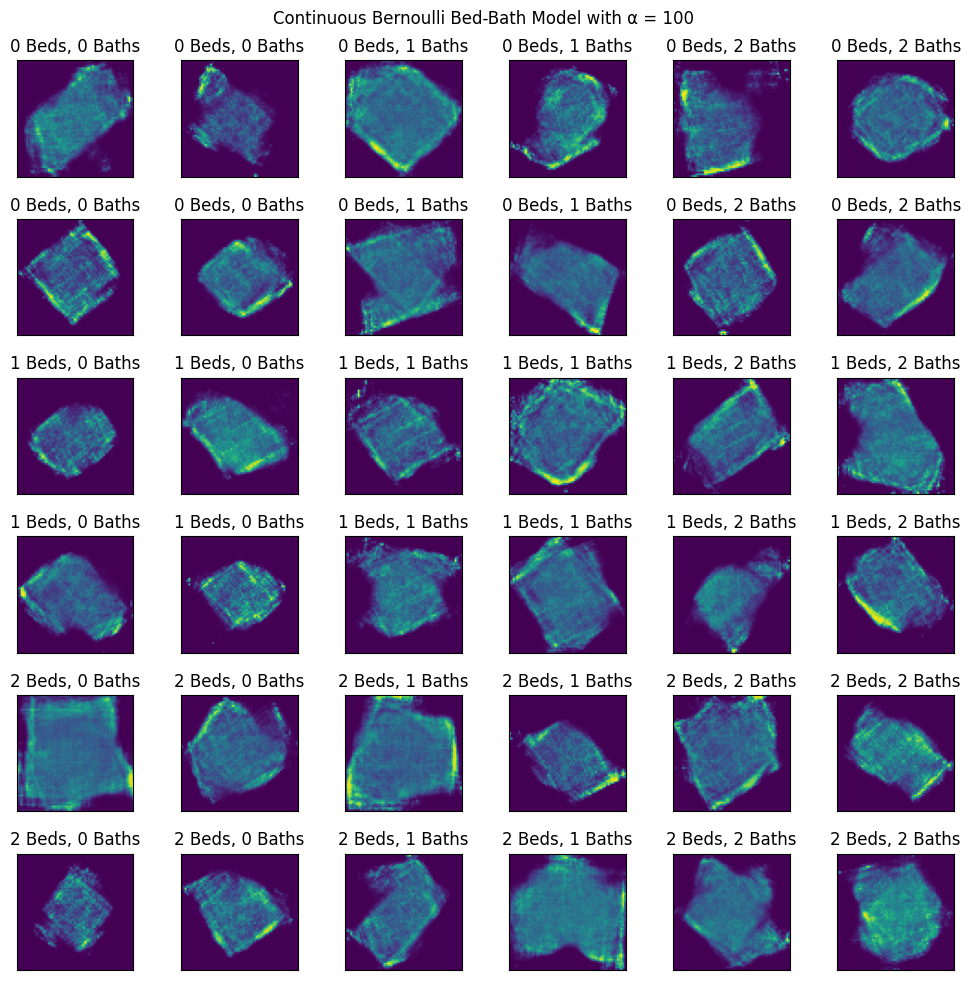

In [54]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(6, 6, sharex=True, sharey=True, figsize=[10, 10])
f.suptitle('Continuous Bernoulli Bed-Bath Model with α = 100')
for beds in range(6):
    for baths in range(6):
        beds_ = beds // 2
        baths_ = baths // 2
        t_bed = Tensor([beds_]).cuda()
        t_bath = Tensor([baths_]).cuda()
        z_loc = tensors[0].new_zeros(torch.Size((1, 64)))
        z_scale = tensors[0].new_ones(torch.Size((1, 64)))
        z = dist.Normal(z_loc, z_scale).sample().cuda()
        decoded = vae.decoder([z, t_bed, t_bath])
        numpy_arr = from_cuda_and_resize(decoded, categorical=False)
        ax = axarr[beds][baths]
        ax.imshow(numpy_arr)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text(f'{beds_} Beds, {baths_} Baths')
plt.tight_layout()

In [55]:
tensors_cat = tensors

In [56]:
tensors_cat[0] = (tensors_cat[0] * 4).type(torch.int)

In [57]:
train_losses_cb_alpha_100 ,test_losses_pd_cb_alpha_100 = train_losses[0], test_losses_pd

In [58]:
tensors_cat[0] = tensors_cat[0].type(torch.float)

In [59]:
pyro.clear_param_store()
vae, train_losses, test_losses = SVAE2.make_vae(tensors_cat, 64, [64 * 4], epochs=101, lr=1e-3, aux_loss_multiplier=100, categories_dim=5, bed_bath_dim=9)

/home/solnik/floor_plans/env/lib/python3.10/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[epoch 000]  average training loss: 2684.8512
[epoch 000]  average training loss: 524.2094
[epoch 000] average test loss: 2252.2631
[epoch 000] average test loss: 516.2200
[epoch 001]  average training loss: 2131.9340
[epoch 001]  average training loss: 472.0354
[epoch 002]  average training loss: 1990.2155
[epoch 002]  average training loss: 440.7788
[epoch 003]  average training loss: 1896.8971
[epoch 003]  average training loss: 452.3702
[epoch 004]  average training loss: 1832.6872
[epoch 004]  average training loss: 509.8028
[epoch 005]  average training loss: 1789.0146
[epoch 005]  average training loss: 456.9183
[epoch 006]  average training loss: 1756.0505
[epoch 006]  average training loss: 493.1417
[epoch 007]  average training loss: 1731.7397
[epoch 007]  average training loss: 456.1828
[epoch 008]  average training loss: 1710.3615
[epoch 008]  average training loss: 521.1176
[epoch 009]  average training loss: 1696.0196
[epoch 009]  average training loss: 449.3205
[epoch 01

[epoch 083]  average training loss: 1558.7394
[epoch 083]  average training loss: 605.1755
[epoch 084]  average training loss: 1561.1182
[epoch 084]  average training loss: 603.1584
[epoch 085]  average training loss: 1559.3484
[epoch 085]  average training loss: 602.9964
[epoch 086]  average training loss: 1561.7529
[epoch 086]  average training loss: 602.7954
[epoch 087]  average training loss: 1559.3191
[epoch 087]  average training loss: 604.4100
[epoch 088]  average training loss: 1559.3158
[epoch 088]  average training loss: 637.3686
[epoch 089]  average training loss: 1559.3416
[epoch 089]  average training loss: 845.5612
[epoch 090]  average training loss: 1558.1014
[epoch 090]  average training loss: 1132.5320
[epoch 090] average test loss: 1709.5835
[epoch 090] average test loss: 1138.5806
[epoch 091]  average training loss: 1558.8014
[epoch 091]  average training loss: 1132.4433
[epoch 092]  average training loss: 1558.5884
[epoch 092]  average training loss: 1132.5306
[epoc

In [60]:
test_losses_pd = pd.Series([np.nan] * 101)
for i in range(10):
    test_losses_pd[10 * i] = test_losses[0][i]
    
test_losses_pd = test_losses_pd.interpolate()

<AxesSubplot: title={'center': 'ELBO Per Epoch for Categorical Bed-Bath Model with α = 100'}>

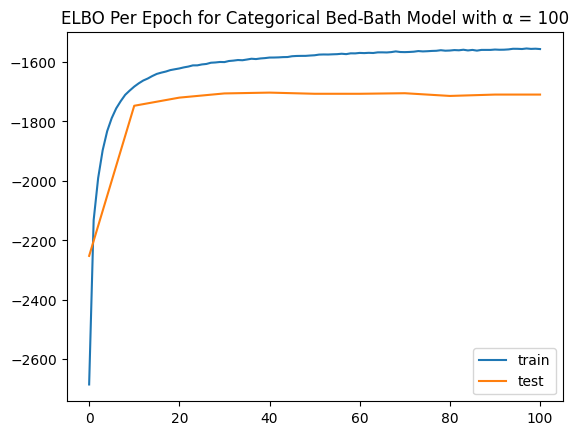

In [61]:
pd.DataFrame({'train': train_losses[0], 'test': test_losses_pd}).plot(title='ELBO Per Epoch for Categorical Bed-Bath Model with α = 100')

In [62]:
train_losses_c_alpha_100 ,test_losses_pd_c_alpha_1000 = train_losses[0], test_losses_pd

<AxesSubplot: title={'center': 'ELBO Per Epoch for Bed-Bath Model with α = 100'}>

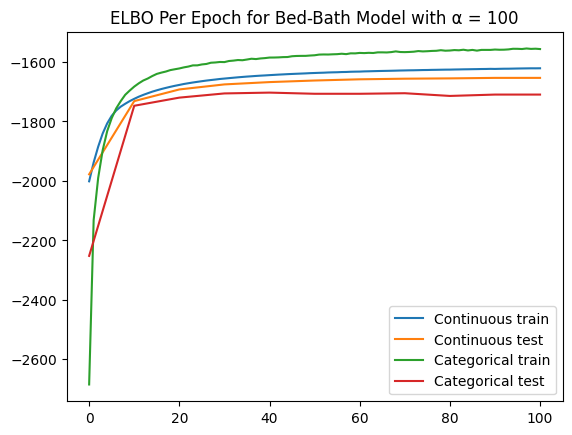

In [113]:
pd.DataFrame(
    {
        'Continuous train': train_losses_cb_alpha_100 ,
        'Continuous test': test_losses_pd_cb_alpha_100,
        'Categorical train': train_losses_c_alpha_100 ,
        'Categorical test': test_losses_pd_c_alpha_1000
    }).plot(title='ELBO Per Epoch for Bed-Bath Model with α = 100')

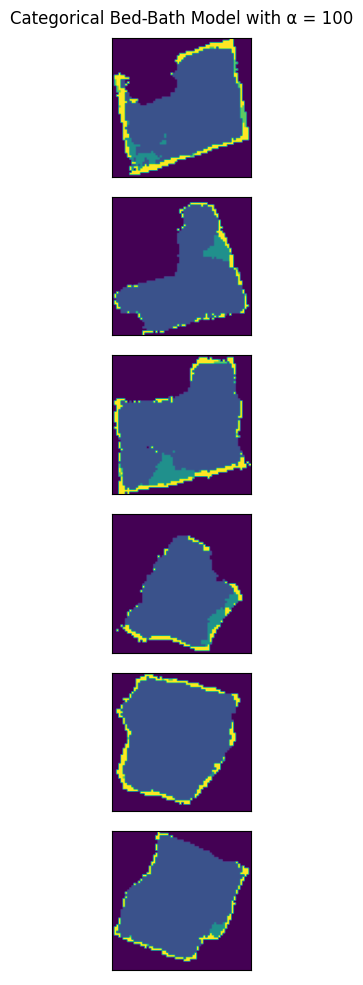

In [63]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(indicies), 1, sharex=True, sharey=True, figsize=[5, 10])
f.suptitle('Categorical Bed-Bath Model with α = 100')
imgs = []
for i, ind in enumerate(indicies):
    pred, real = get_pred_and_real(vae, tensors, ind, categorical=True)
    axarr[i].imshow(pred)
    imgs.append(pred)
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [64]:
save(imgs, 'Categorical Bed-Bath Model with alpha 100')

SAVING /home/solnik/floor_plans/Final Projects/pickles/Categorical Bed-Bath Model with alpha 100 


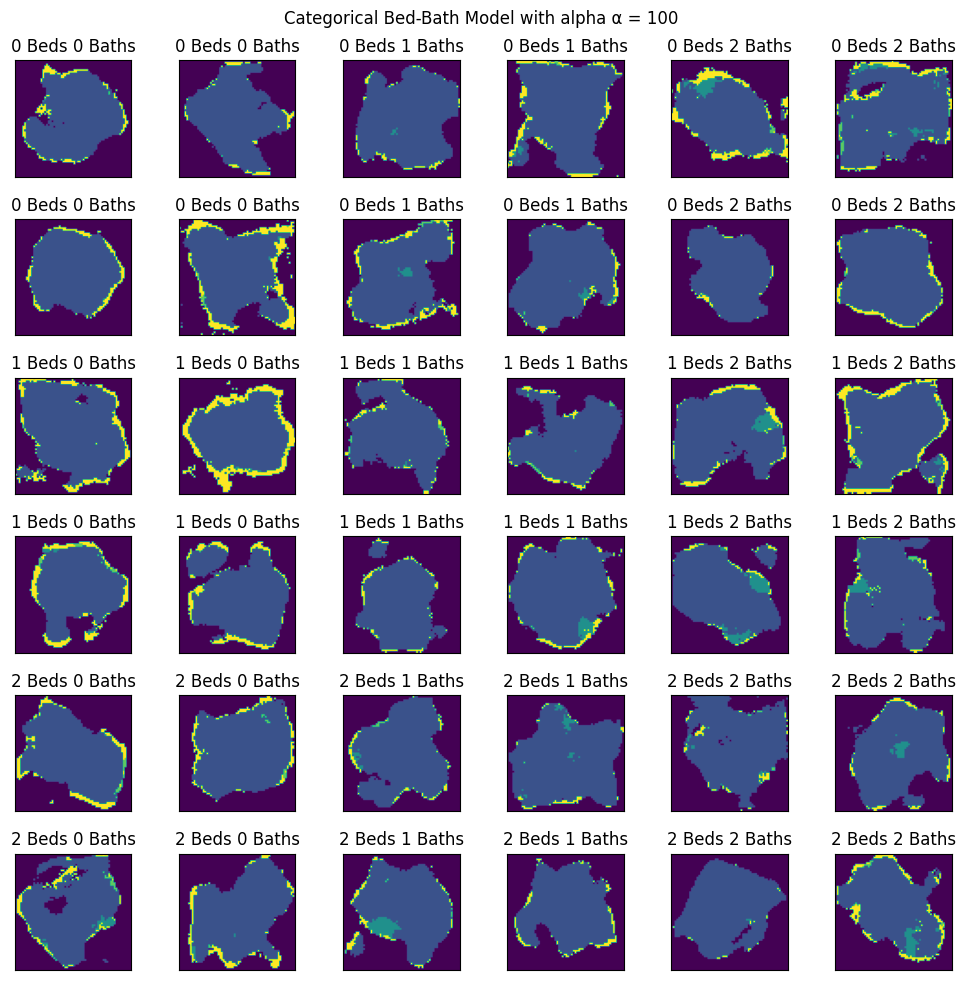

In [81]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(6, 6, sharex=True, sharey=True, figsize=[10, 10])
f.suptitle('Categorical Bed-Bath Model with alpha α = 100')
for beds in range(6):
    for baths in range(6):
        beds_ = beds // 2
        baths_ = baths // 2
        t_bed = Tensor([beds_]).cuda()
        t_bath = Tensor([baths_]).cuda()
        z_loc = tensors[0].new_zeros(torch.Size((1, 64)))
        z_scale = tensors[0].new_ones(torch.Size((1, 64)))
        z = dist.Normal(z_loc, z_scale).sample().cuda()
        decoded = vae.decoder([z, t_bed, t_bath])
        numpy_arr = from_cuda_and_resize(decoded, categorical=True)
        ax = axarr[beds][baths]
        ax.imshow(numpy_arr)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text(f'{beds_} Beds {baths_} Baths')
plt.tight_layout()

In [82]:
train_losses_c_alpha_100 ,test_losses_pd_c_alpha_100 = train_losses[0], test_losses_pd

In [84]:
pyro.clear_param_store()
vae, train_losses, test_losses = SVAE2.make_vae(tensors_cat, 64, [64 * 4], epochs=101, lr=1e-3, aux_loss_multiplier=None, categories_dim=5, bed_bath_dim=9)

[epoch 000]  average training loss: 2717.5505
[epoch 000] average test loss: 2284.7418
[epoch 001]  average training loss: 2154.1553
[epoch 002]  average training loss: 2013.3233
[epoch 003]  average training loss: 1917.4747
[epoch 004]  average training loss: 1853.8408
[epoch 005]  average training loss: 1810.8791
[epoch 006]  average training loss: 1780.1673
[epoch 007]  average training loss: 1754.9236
[epoch 008]  average training loss: 1735.8239
[epoch 009]  average training loss: 1721.4590
[epoch 010]  average training loss: 1708.4779
[epoch 010] average test loss: 1776.0246
[epoch 011]  average training loss: 1698.0623
[epoch 012]  average training loss: 1687.8423
[epoch 013]  average training loss: 1682.3303
[epoch 014]  average training loss: 1675.7795
[epoch 015]  average training loss: 1668.0138
[epoch 016]  average training loss: 1662.1999
[epoch 017]  average training loss: 1658.2940
[epoch 018]  average training loss: 1654.1600
[epoch 019]  average training loss: 1650.472

In [85]:
test_losses_pd = pd.Series([np.nan] * 101)
for i in range(10):
    test_losses_pd[10 * i] = test_losses[0][i]
    
test_losses_pd = test_losses_pd.interpolate()
train_losses_c_alpha_0 ,test_losses_pd_c_alpha_0 = train_losses[0], test_losses_pd

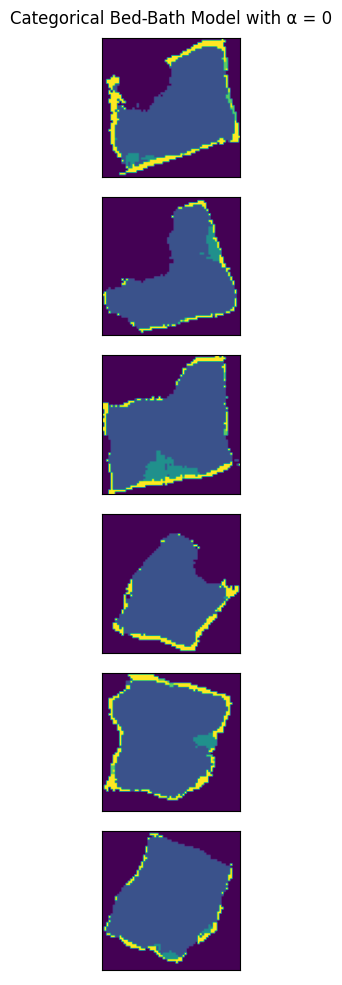

In [86]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(indicies), 1, sharex=True, sharey=True, figsize=[5, 10])
f.suptitle('Categorical Bed-Bath Model with α = 0')
imgs = []
for i, ind in enumerate(indicies):
    pred, real = get_pred_and_real(vae, tensors, ind, categorical=True)
    axarr[i].imshow(pred)
    imgs.append(pred)
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [87]:
save(imgs, 'Categorical Bed-Bath Model with alpha 0')

SAVING /home/solnik/floor_plans/Final Projects/pickles/Categorical Bed-Bath Model with alpha 0 


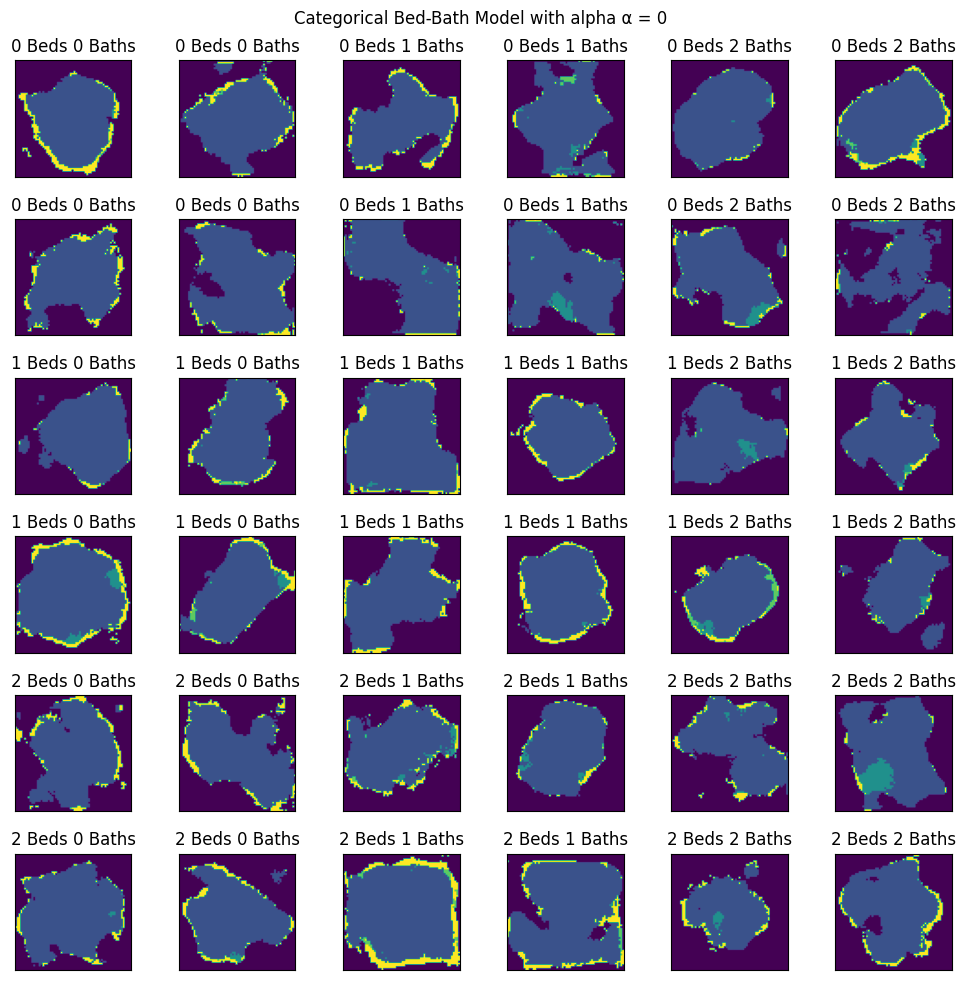

In [89]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(6, 6, sharex=True, sharey=True, figsize=[10, 10])
f.suptitle('Categorical Bed-Bath Model with alpha α = 0')
for beds in range(6):
    for baths in range(6):
        beds_ = beds // 2
        baths_ = baths // 2
        t_bed = Tensor([beds_]).cuda()
        t_bath = Tensor([baths_]).cuda()
        z_loc = tensors[0].new_zeros(torch.Size((1, 64)))
        z_scale = tensors[0].new_ones(torch.Size((1, 64)))
        z = dist.Normal(z_loc, z_scale).sample().cuda()
        decoded = vae.decoder([z, t_bed, t_bath])
        numpy_arr = from_cuda_and_resize(decoded, categorical=True)
        ax = axarr[beds][baths]
        ax.imshow(numpy_arr)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.title.set_text(f'{beds_} Beds {baths_} Baths')
plt.tight_layout()

In [98]:
tensors[0] = tensors[0] / 4

In [100]:
pyro.clear_param_store()
vae, train_losses, test_losses = SVAE2.make_vae(tensors, 64, [64 * 4], epochs=101, lr=1e-3, aux_loss_multiplier=None, bed_bath_dim=9)

[epoch 000]  average training loss: 1997.1882
[epoch 000] average test loss: 1952.2824
[epoch 001]  average training loss: 1921.8301
[epoch 002]  average training loss: 1890.5662
[epoch 003]  average training loss: 1842.1254
[epoch 004]  average training loss: 1808.4983
[epoch 005]  average training loss: 1783.6825
[epoch 006]  average training loss: 1766.1040
[epoch 007]  average training loss: 1752.6209
[epoch 008]  average training loss: 1741.7853
[epoch 009]  average training loss: 1733.2997
[epoch 010]  average training loss: 1725.6687
[epoch 010] average test loss: 1734.6800
[epoch 011]  average training loss: 1718.7627
[epoch 012]  average training loss: 1712.3110
[epoch 013]  average training loss: 1706.4069
[epoch 014]  average training loss: 1701.0110
[epoch 015]  average training loss: 1695.9316
[epoch 016]  average training loss: 1691.5829
[epoch 017]  average training loss: 1687.6420
[epoch 018]  average training loss: 1683.8568
[epoch 019]  average training loss: 1680.575

In [101]:
test_losses_pd = pd.Series([np.nan] * 101)
for i in range(10):
    test_losses_pd[10 * i] = test_losses[0][i]
    
test_losses_pd = test_losses_pd.interpolate()

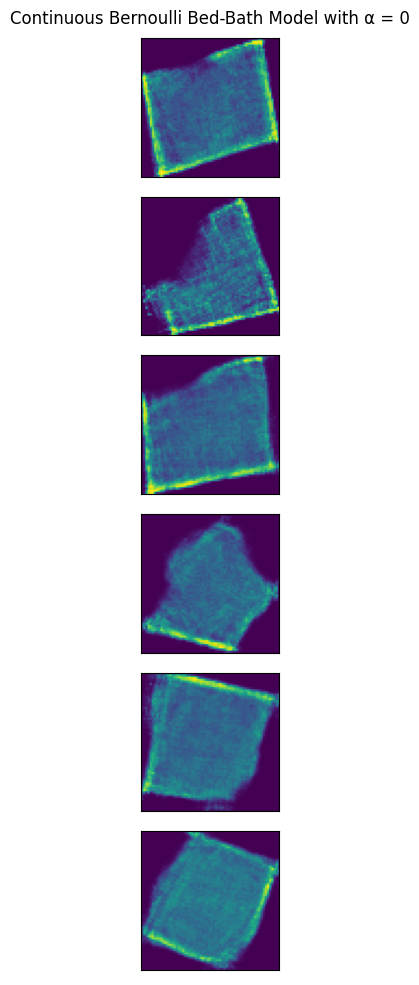

In [103]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(indicies), 1, sharex=True, sharey=True, figsize=[5, 10])
f.suptitle('Continuous Bernoulli Bed-Bath Model with α = 0')
imgs = []
for i, ind in enumerate(indicies):
    pred, real = get_pred_and_real(vae, tensors, ind, categorical=False)
    imgs.append(pred)
    axarr[i].imshow(pred)
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [104]:
save(imgs, 'Continuous Bed-Bath Model with alpha 0')

SAVING /home/solnik/floor_plans/Final Projects/pickles/Continuous Bed-Bath Model with alpha 0 


<AxesSubplot: title={'center': 'ELBO Per Epoch for Bed-Bath Model with α = 0'}>

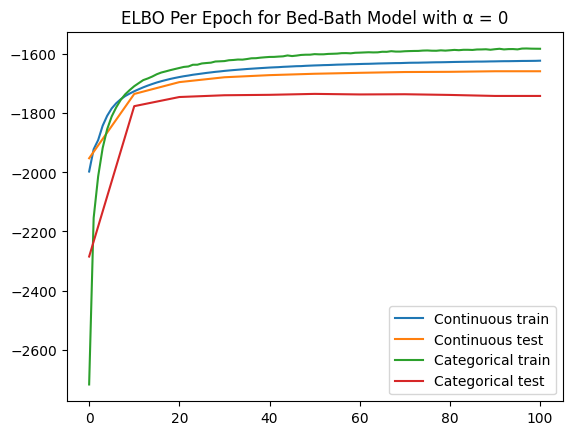

In [112]:
pd.DataFrame(
    {
        'Continuous train': train_losses[0], 
        'Continuous test': test_losses_pd,
        'Categorical train': train_losses_c_alpha_0 ,
        'Categorical test': test_losses_pd_c_alpha_0
    }).plot(title='ELBO Per Epoch for Bed-Bath Model with α = 0')